## Build a classifier using a pre-trained network
In this kernel we will implement a transfer learning approach to classify the histopathological images. This means that we will not build from scratch our own network, but instead we will "borrow" the architecture and the weights from a pre-existing model, which has already been trained on some dataset. We will then adapt the weights to suit our own classification problem.

In [1]:
# needed to make the plots visible
%matplotlib inline

# import modules
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


### Get the data
Build a dataframe with image ids and corresponding label (0 = no tumor tissue, 1 = has tumor tissue).
The images are inside the `input` folder, subdivided in training and testing images. A `.csv` file in the `input` folder provides the labels corresponding to each image id.

In [2]:
df_data = pd.read_csv('D:/Kaggle/HistoPat/input/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

We now create the train and validation dataframes

In [3]:
df_data.reset_index(drop=True)
df_data = shuffle(df_data)

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=62, stratify=y)

print(df_train.shape)
print(df_val.shape)

df_train['label'].value_counts()
df_val['label'].value_counts()

(198022, 2)
(22003, 2)


0    13091
1     8912
Name: label, dtype: int64

In [4]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

So far we have created dataframes with only the image index and the corresponding labels. We won't load into memory all the images at the same time, to avoid the kernel dying. Instead, the images will be copied in different subfolders for training and validation, each with two subfolders corresponding to the two classes. The structure looks like this:
 - base_dir
     - train_dir
         - a_no_tumor_tissue
         - b_has_tumor_tissue
     - val_dir
         - a_no_tumor_tissue
         - b_has_tumor_tissue

In [ ]:
# Create a new directory
base_dir = 'D:/Kaggle/HistoPat/base_dir'
os.mkdir(base_dir)

#create train_dir and val_dir
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create classes subfolders

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

And now transfer the images inside the respective folders (might take a while since here we are using all the images)

In [ ]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('./input/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('./input/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

### Data pre-processing

Now that our data is sorted the way we need it, we can perform some data augmentation. In this way the network will be trained with different versions of the same images (e.g. rotated images, mirrored images, zoom-ins, etc.), thus allowing for more robust predictions.

Keras offers some basic transformations via the `ImageDataGenerator` class. A wider set of possible transformations, which we will use here, is provided in the `imgaug` library https://github.com/aleju/imgaug

In [5]:
train_path = 'D:/Kaggle/HistoPat/base_dir/train_dir'
valid_path = 'D:/Kaggle/HistoPat/base_dir/val_dir'
test_path = 'D:/Kaggle/HistoPat/input/test'

train_batch_size = 32
val_batch_size = 32

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0, 10)), # crop images from each side by 0 to 20px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images,
    iaa.Flipud(0.3), # vertically flip 30% of the images,
    iaa.Sometimes(0.5, iaa.OneOf([iaa.Sharpen(alpha=(0,0.2), lightness=(0.9,1.1)), iaa.Emboss(alpha=0.3, strength=0.3),
                                 ]),
                  iaa.OneOf([iaa.Dropout(0.12), iaa.SaltAndPepper(0.15)])
                 )
    ],
    random_order=False
)

We will combine the augmenters above with a custom function that normalizes the pixels in the image, to ensure faster convergence of the network training.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

img_size = 96

def normalize_image(x):
    '''normalize pixel values for each image so that they have zero mean'''
    if x.std() > 0:
        return (x - x.mean())/x.std()
    else:
        return x
    
def combined_augmentation(x):
    '''
    combine (one after the other) augmentation from imgaug with normalize_image(x)
    '''
    x = seq.augment_image(x)
    x = normalize_image(x)
    return x

We will still use the `ImageDataGenerator` class to create the generators, which will take batches of images from the folders created above.

In [8]:
datagen = ImageDataGenerator(preprocessing_function=combined_augmentation)

#for data validation we will only use the normalization, no augmentation
datagen_val = ImageDataGenerator(preprocessing_function=normalize_image)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen_val.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# shuffle=False causes the test dataset to not be shuffled
test_gen = datagen_val.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


It is very important to observe the changes produced by the preprocessing functions on the images. Too severe modifications to the images might affect the performance of the model.
We will take one image and check a few transformed versions.

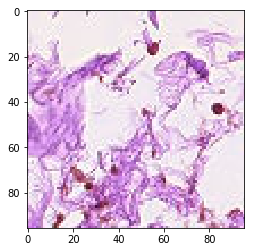

In [9]:
image_path = 'D:/Kaggle/HistoPat/base_dir/train_dir/a_no_tumor_tissue/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif'

img = cv2.imread(image_path)
plt.imshow(img)
plt.show()

This is the original image. 

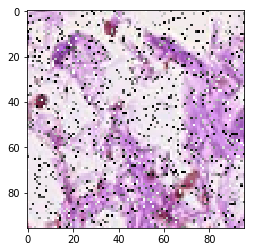

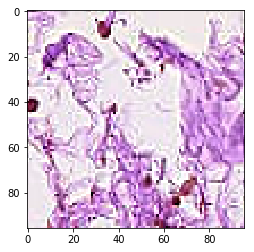

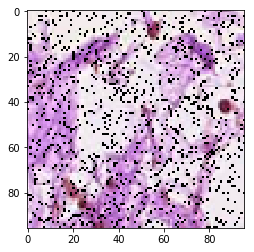

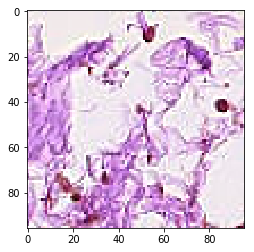

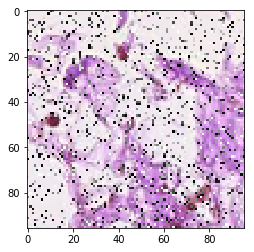

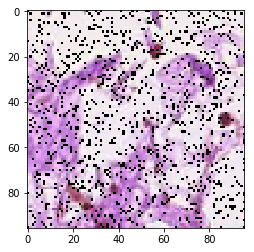

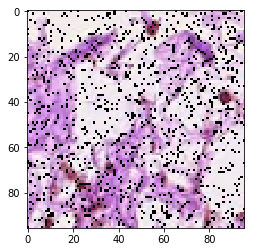

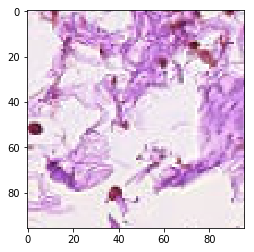

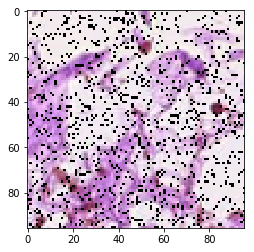

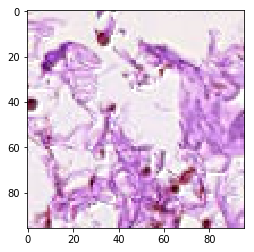

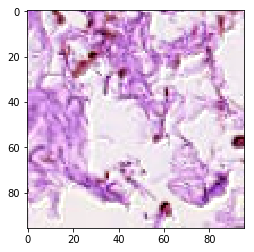

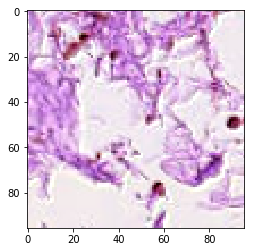

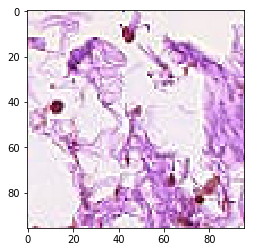

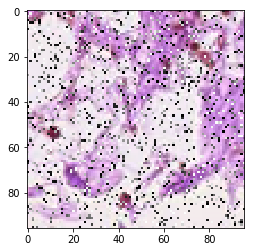

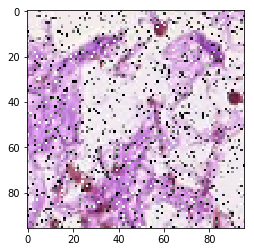

In [10]:
datagen_plot = ImageDataGenerator(preprocessing_function=seq.augment_image)
# reshape image in the appropriate format
img = img.reshape((1,)+img.shape)
plot_gen = datagen_plot.flow(img)

num_examples = 15
for i in range(0, num_examples):                     
    x_batch = next(plot_gen)
    image = x_batch[0]
    image = image/255.
    plt.imshow(image)
    plt.show()

These are the modified versions of the image, which will be given in the training phase to the model. If the modifications are too heavy it could be a good idea to reduce the number or the strength of the transformations

### Build the model
Instead of bulding a model from scratch, we will use a pre-exisiting architecture with pre-trained weights. Specifically here we chose the VGG-16 network (https://arxiv.org/pdf/1409.1556.pdf), trained on the ImageNet database, and at the end of the network we attach a couple of fully-connected layers. 

In [11]:
def get_model_classif_vgg16():
    
    inputs = Input((96, 96, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = BatchNormalization()(out)
    out = Dropout(0.7)(out)    
    out = Dense(512, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dropout(0.7)(out)
    out = Dense(256, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dropout(0.7)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [12]:
model = get_model_classif_vgg16()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 3, 3, 512)    14714688    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[1][0]                      
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg16[1][0]                      
__________________________________________________________________________________________________
flatten_1 

As the VGG16 network is already pre-trained, while the last fully-connected layers are not, it is advisable to first train only the last layers, keeping the weights of the VGG16 part fixed, as in the first epochs the learning process might negatively affect them.

In [13]:
model.layers[1].trainable = False
model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])

After a few training epochs we will unfreeze this part of the model and train everything together.

### Training phase

To compensate for the class imbalance we calculate the relative weights of the two classes and use it during the training process

In [14]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train['label']),
                                                 df_train['label'])

In [ ]:
import time 
from keras import backend as K

#epochs for training of only the last fully-connected layers
epochs_tail = 3
#epochs for training of the full model
epochs_full = 6

h5_path = "weights_VGG16_TTA_v02_3tail6full.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reducel = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.2)

start = time.time()

history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_tail, verbose=1,
    callbacks=[checkpoint, reducel],
    steps_per_epoch=len(df_train) // train_batch_size,
    validation_steps=len(df_val) // val_batch_size,
    class_weight=class_weights
)

#unfreeze VGG16 part and train all toghether
model.layers[1].trainable = True
#extract learning rate from training so far
lr_sofar = K.get_value(model.optimizer.lr)
model.compile(optimizer=Adam(lr_sofar), loss=binary_crossentropy, metrics=['acc'])

history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_full, verbose=1,
    callbacks=[checkpoint, reducel],
    steps_per_epoch=len(df_train) // train_batch_size,
    validation_steps=len(df_val) // val_batch_size,   
    class_weight=class_weights
)

#plot accuracies 
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='r')
plt.title('Model Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation accuracy'], loc='best')
plt.show()

#plot losses
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.title('Model Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')
plt.show()

end = time.time()
print("Elapsed time for training: " + str((end - start)/60) + " minutes.")

### Model evaluation
Calculate area under ROC curve

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

model.load_weights('../weights_VGG16_TTA_v02_3tail6full.h5')

y_pred_val = model.predict_generator(test_gen, verbose=1, steps=len(df_val))
fpr_keras, tpr_keras, _ = roc_curve(test_gen.classes, y_pred_val)

auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

22003/22003 [==============================] - 474s 22ms/step


0.989349545413839

Plot ROC curve

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Understand the predictions
It is typically useful to try to understand where the model failed to correctly classify the images. To do so we can plot the "mostly misclassified" images, which means the images for which there is the largest difference between true and predicted label.

Let's first have a look at the distribution of such difference:

In [ ]:
y_diff = abs(y_pred_val - test_gen.classes.reshape(len(y_pred_val),1))

h = plt.hist(y_diff, 30, range=(0.05,1))
plt.show()

The histogram is obviously peaked at zero, since the model predicts the correct label for the vast majority of the validation images. For this reason we only plot it starting from differences of at least 0.05, in order to resolve the details of the rest of the plot. As it could be expected, there are less and less images as the difference between true and predicted labels increase. However we observe a sudden increase in the number of images for the last bin of the histogram. The reason for that is not clear. 

Now let's plot some of the images with the largest difference in labels:

In [ ]:
def plot_misclassified_images(num_img):
    '''
    Function to plot the images which received
    the wrongest prediction label
    '''
    #create a vector of the absolute differences between true and predicted labels
    y_diff = abs(y_pred_val - test_gen.classes.reshape(len(y_pred_val),1))
    
    #find indices of the num_img largest elements of y_diff
    ind = np.argpartition(y_diff, -num_img, axis=0)[-num_img:]
    
    #from the indices obtain the corresponding images in the val_dir folder
    names = []
    paths = []
    for i in range(0,len(ind)):
        names.append(test_gen.filenames[int(ind[i])])
        paths.append(names[i].replace("\\","/"))
        paths[i] = 'D:/Kaggle/HistoPat/base_dir/val_dir/'+paths[i]
        
    #plot the images
    fig, m_axs = plt.subplots(1, num_img, figsize=(18,2))
    for ii, c_ax in enumerate(m_axs):
        img = cv2.imread(paths[ii])
        if paths[ii].find('a_no_tumor_tissue') > 0:
            c_ax.set_title("True label: \n 0")
        else:
            c_ax.set_title("True label: \n 1")
        c_ax.text(48, 155, 'Pred label: \n '+str(np.round(y_pred_val[ind[ii]])), size=12, ha='center')
        c_ax.imshow(img)

In [ ]:
plot_misclassified_images(10)

To an untrained eye like mine it is hard to see any common features of all these images, which might have helped in understanding where and how the model is poorly performing.

#### Predictions on the test set
Similarly to what has been done for the training phase, we define a folder structure also for the test images (with no subdivision in classes, since it is now known).

In [ ]:
# create test_dir
test_dir = 'D:/Kaggle/HistoPat/test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [ ]:
# Transfer the test images into image_dir

test_list = os.listdir('./input/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('./input/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

A small trick which has proven extremely useful to improve the model's performance is Test-Time Augmentation (TTA). Before being fed to the model, the test images are pre-processed using the same transformations used in the training phase. Some transformations might help the model to correctly classify an image, while other transformations might hinder the process. For this reason the test set is passed several times to the model, and every time the images are transformed differently. For each pass the model will predict the images' labels. At the end the multiple predictions for each image are averaged, possibly yielding a more accurate result. This comes at the cost of a longer testing phase.

In [ ]:
num_test_images = 57458
#model.load_weights('weights_VGG16_TTA_v02_3tail6full.h5')

test_path = 'D:/Kaggle/HistoPat/test_dir'

real_test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(img_size, img_size),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

#number of times we feed the entire test set to the model
tta_steps = 10

predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(real_test_gen, steps=num_test_images, verbose=1)
    predictions.append(preds)
    
avg_pred = np.mean(predictions, axis=0)